In [14]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from arcade_dataset import ArcadeDataset, load_dataset
import cv2
import matplotlib.patches as patches
import matplotlib.colors as mcolors


In [2]:
data_path = 'data/arcade/syntax/val'
imgs_path = data_path + '/images'
annots_path = data_path + '/annotations'
imgs = sorted(os.listdir(imgs_path))
annots = json.load(open(annots_path + '/val.json'))['annotations']

In [3]:
annots[0].keys()

dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd', 'attributes'])

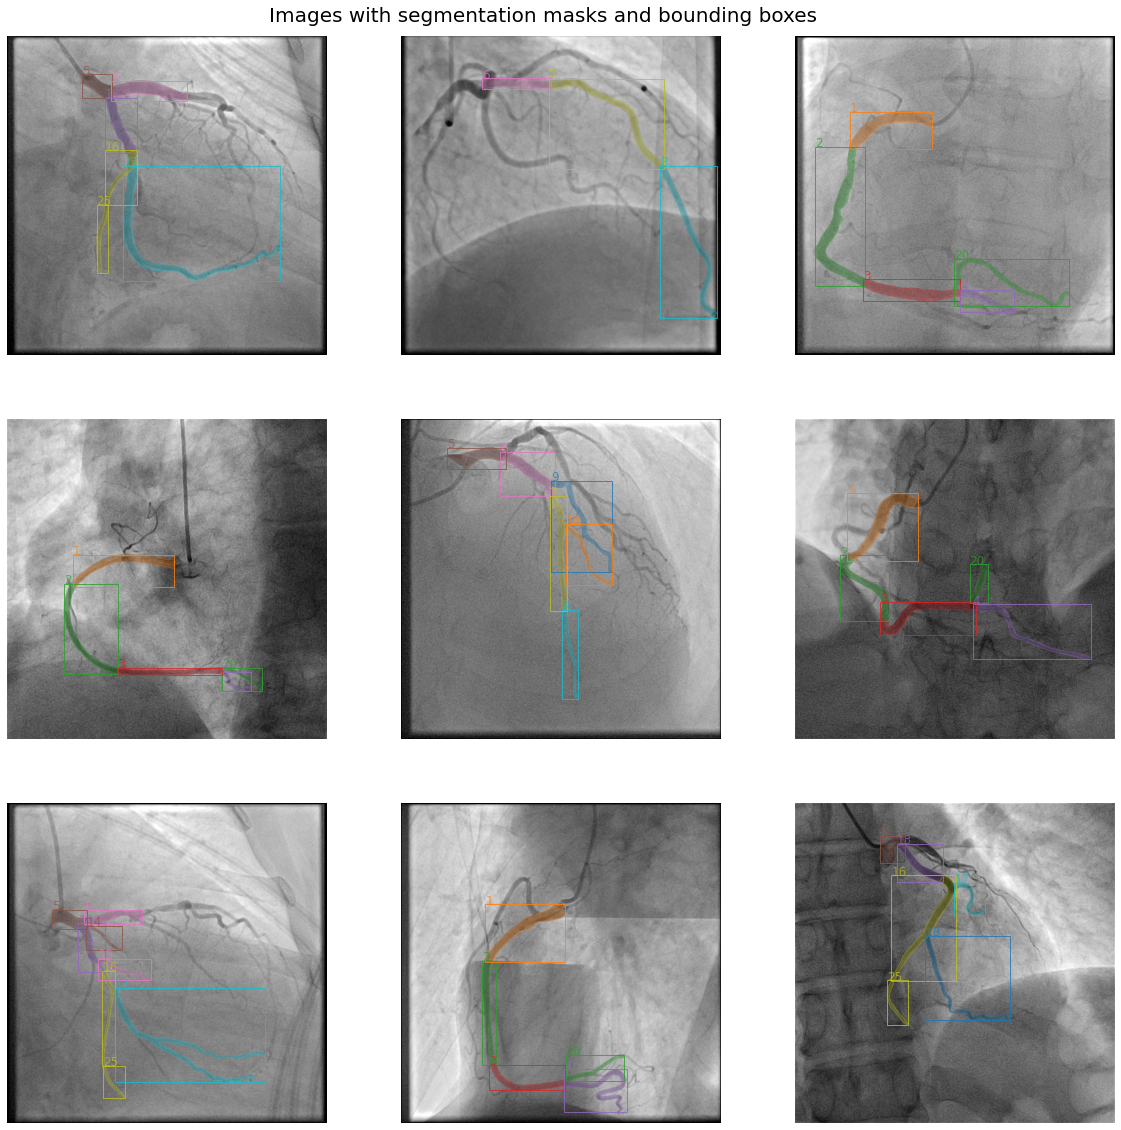

In [4]:
custom_colors = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
    'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan'
]

def get_color(category_id):
    return custom_colors[category_id % len(custom_colors)]

# Number of images to display
k = 3
plt.subplots(k, k, figsize=(20, 20))
plt.suptitle('Images with segmentation masks and bounding boxes', fontsize=20, y=0.9)

for i, img in enumerate(imgs[:k*k]):
    plt.subplot(k, k, i + 1)
    plt.imshow(plt.imread(imgs_path + '/' + img), cmap='gray')
    plt.axis('off')
    
    # Segmentation mask
    for j, annot in enumerate(annots):
        if annot['image_id'] == i + 1:
            color = get_color(annot['category_id'])
            for seg in annot['segmentation']:
                plt.fill(seg[0::2], seg[1::2], alpha=0.3, color=color)

    # Bounding boxes
    for j, annot in enumerate(annots):
        if annot['image_id'] == i + 1:
            x, y, w, h = annot['bbox']
            color = get_color(annot['category_id'])
            plt.gca().add_patch(patches.Rectangle((x, y), w, h, linewidth=0.8, edgecolor=color, facecolor='none'))
            plt.text(x, y, str(annot['category_id']), fontsize=12, alpha=0.7, color=color)

plt.show()


In [6]:
# Visualize the images and masks
def visualize_batch(batch, batch_idx):
    num_images = 5
    fig, axes = plt.subplots(4, num_images, figsize=(20, 15))
    
    # Titles for each row
    row_titles = ['Original Image', 'Transformed Image (Top Hat)', 'Transformed Image (Canny Edge)', 'Mask']
    
    for row_idx, row_title in enumerate(row_titles):
        # Display row title
        axes[row_idx, 0].set_ylabel(row_title, fontsize=16, labelpad=20)
        
        for i in range(num_images):
            ax = axes[row_idx, i]
            if row_idx == 0:  # Original Image
                ax.imshow(batch['original_image'][i].squeeze().cpu().numpy(), cmap='gray')
            elif row_idx == 1:  # Transformed Image (Top Hat)
                ax.imshow(batch['transformed_image'][i].permute(1, 2, 0).cpu().numpy()[:,:,1], cmap='gray')
            elif row_idx == 2:  # Transformed Image (Canny Edge)
                ax.imshow(batch['transformed_image'][i].permute(1, 2, 0).cpu().numpy()[:,:,2], cmap='gray')
            else:  # Mask
                ax.imshow(batch['masks'][i].squeeze().cpu().numpy(), cmap='gray')
            
            ax.axis('off')

    plt.suptitle(f'Batch {batch_idx}', fontsize=20)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

In [15]:
# Custom colors for classes
custom_colors = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
    'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan'
]

def get_color(category_id):
    return custom_colors[category_id % len(custom_colors)]

# Visualize the images and masks
def visualize_batch(batch, batch_idx, num_classes=21):
    num_images = 5
    fig, axes = plt.subplots(5, num_images, figsize=(20, 20))
    
    # Titles for each row
    row_titles = ['Original Image', 'Transformed Image (Top Hat)', 'Transformed Image (Canny Edge)', 'Mask', 'Separate Masks']
    
    for row_idx, row_title in enumerate(row_titles):
        # Display row title
        axes[row_idx, 0].set_ylabel(row_title, fontsize=16, labelpad=20)
        
        for i in range(num_images):
            ax = axes[row_idx, i]
            if row_idx == 0:  # Original Image
                ax.imshow(batch['original_image'][i].squeeze().cpu().numpy(), cmap='gray')
            elif row_idx == 1:  # Transformed Image (Top Hat)
                ax.imshow(batch['transformed_image'][i].permute(1, 2, 0).cpu().numpy()[:,:,1], cmap='gray')
            elif row_idx == 2:  # Transformed Image (Canny Edge)
                ax.imshow(batch['transformed_image'][i].permute(1, 2, 0).cpu().numpy()[:,:,2], cmap='gray')
            elif row_idx == 3:  # Mask
                ax.imshow(batch['masks'][i].squeeze().cpu().numpy(), cmap='gray')
            else:  # Separate Masks
                ax.imshow(batch['original_image'][i].squeeze().cpu().numpy(), cmap='gray')
                for class_id in range(num_classes):
                    mask = batch['separate_masks'][i, class_id].cpu().numpy()
                    if np.any(mask):
                        color = get_color(class_id)
                        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                        for contour in contours:
                            ax.add_patch(patches.Polygon(contour.squeeze(), closed=True, fill=True, edgecolor=color, facecolor=color, alpha=0.3))
                            x, y, w, h = cv2.boundingRect(contour)
                            ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=0.8, edgecolor=color, facecolor='none'))
                            ax.text(x, y, str(class_id), fontsize=12, alpha=0.7, color=color)

            ax.axis('off')

    plt.suptitle(f'Batch {batch_idx}', fontsize=20)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

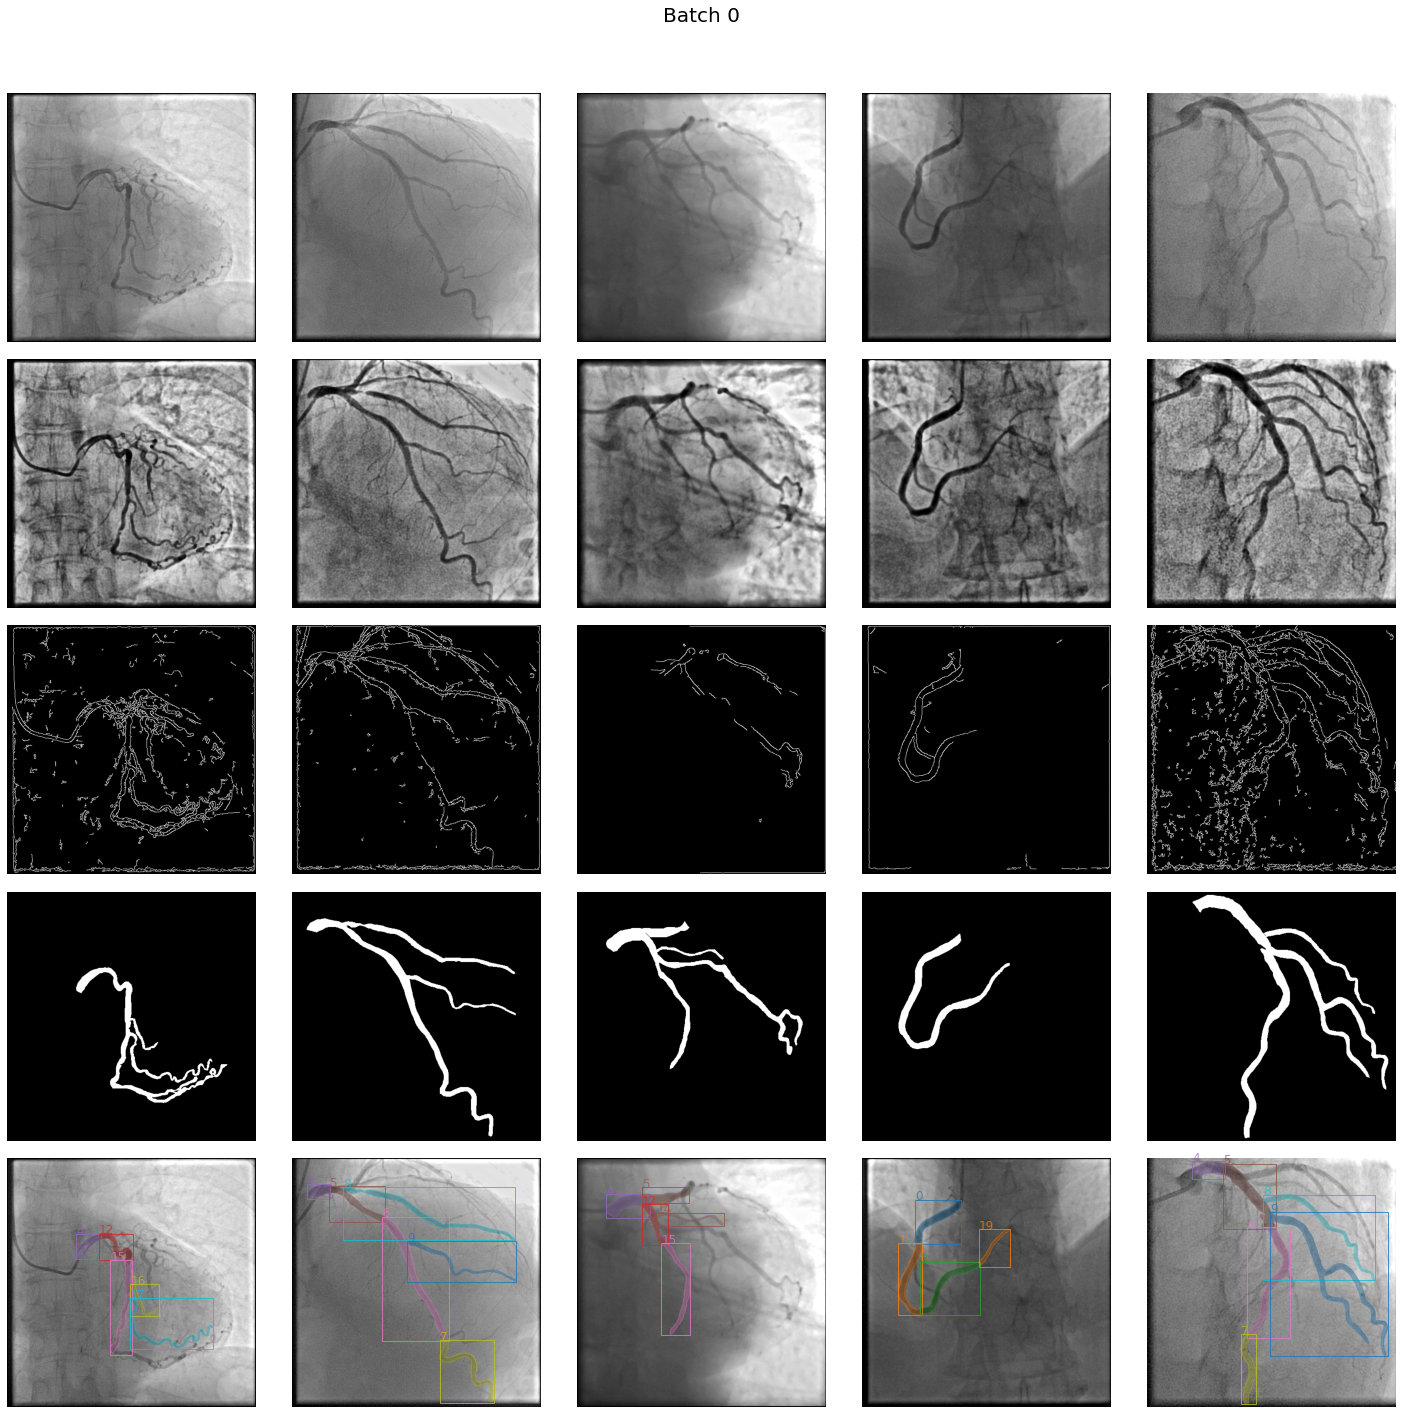

In [16]:
# Example usage for loading and visualizing a specific dataset
batch_size = 16
dataloader_train = load_dataset('train', shuffle=True, batch_size=batch_size, num_workers=0)
# dataloader_val = load_dataset('val', shuffle=False, batch_size=batch_size, num_workers=0)
# dataloader_test = load_dataset('test', shuffle=False, batch_size=batch_size, num_workers=0)

# Visualize a batch from the training set
for batch_idx, batch in enumerate(dataloader_train):
    visualize_batch(batch, batch_idx)
    break